In [1]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime as dt
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\pmuellner\Desktop\DataLeakageKNN\algorithms\knn_neighborhood.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [2]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t")
data_df.columns = ["user_id", "item_id", "rating", "timestamp"]
data_df.drop(columns=["timestamp"], axis=1, inplace=True)
data_df["user_id"] = data_df["user_id"].map({b: a for a, b in enumerate(data_df["user_id"].unique())})
data_df["item_id"] = data_df["item_id"].map({b: a for a, b in enumerate(data_df["item_id"].unique())})

reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader=reader)
trainset, testset = train_test_split(dataset, 0.2)

In [3]:
%matplotlib inline

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until


97.81381381381382

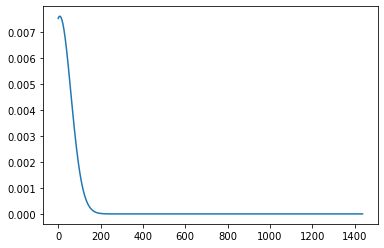

In [57]:
model = UserKNN(k=10)
model.fit(trainset)
_ = model.test(testset)

userknn_scores = np.zeros((model.trainset.n_users))
userknn_scores = model.n_queries

counts, edges = np.histogram(userknn_scores, bins=100)
kde = KernelDensity(bandwidth=50.0, kernel='gaussian')
kde.fit(counts.reshape(-1, 1))
logprob = kde.score_samples(np.linspace(0, np.max(edges), 1000).reshape(-1, 1))
plt.plot(np.linspace(0, np.max(edges), 1000), np.exp(logprob))
threshold = np.linspace(0, np.max(edges), 1000)[np.argmax(np.gradient(np.gradient(np.exp(logprob))))]
threshold

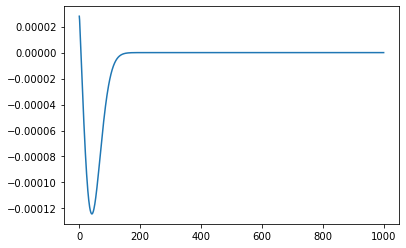

In [91]:
plt.plot(np.gradient(np.exp(logprob)))

In [63]:
def gini(x):
    x = x#np.abs(np.array(x) - 1)
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [64]:
gini(userknn_scores)

0.4211217345780585

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until


90.1901901901902

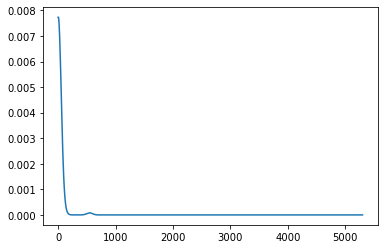

In [50]:
model = UserKNN(k=10, tau_4=0.5, reuse=True)
model.fit(trainset)
_ = model.test(testset)

reuseknn_scores = np.zeros((model.trainset.n_users))
reuseknn_scores = model.n_queries
"""for alice, secrets in model.known_secrets.items():
    for bob, _ in secrets:
        userknn_scores[bob] += 1"""

"""for bob, score in model.exposure_u.items():
    reuseknn_scores[bob] = score"""

counts, edges = np.histogram(reuseknn_scores, bins=100)
kde = KernelDensity(bandwidth=50.0, kernel='gaussian')
kde.fit(counts.reshape(-1, 1))
logprob = kde.score_samples(np.linspace(0, np.max(edges), 1000).reshape(-1, 1))
plt.plot(np.linspace(0, np.max(edges), 1000), np.exp(logprob))
t = np.linspace(0, np.max(edges), 1000)[np.argmax(np.gradient(np.gradient(np.exp(logprob))))]
t

In [65]:
gini(reuseknn_scores)

0.7907711386445574

In [110]:
counts, edges = np.histogram(reuseknn_scores, bins=100)
kde = KernelDensity(bandwidth=50.0, kernel='gaussian')
kde.fit(counts.reshape(-1, 1))
x = np.linspace(0, np.max(edges), 1000)
logprob = kde.score_samples(x.reshape(-1, 1))
x_ = np.exp(logprob)

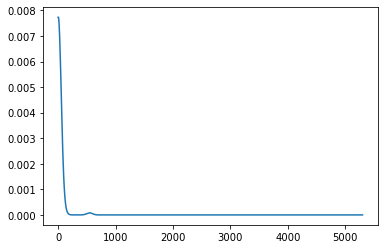

In [111]:
plt.plot(x, x_)

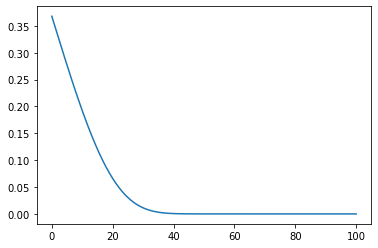

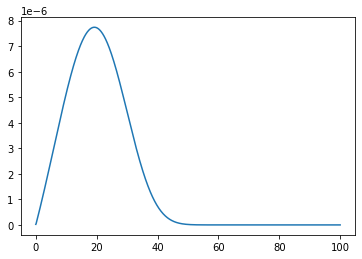

In [149]:
x = np.linspace(0, 100, 1000)
x_ = 1 / np.exp(np.exp(0.05 * x))
plt.figure()
plt.plot(x, x_)
plt.figure()
plt.plot(x, np.gradient(np.gradient(x_)))

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


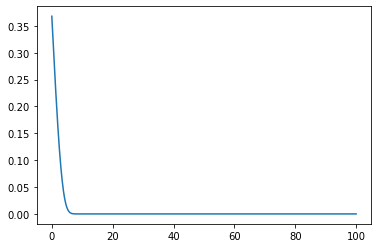

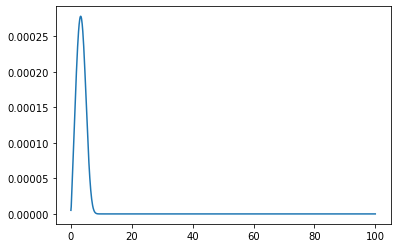

In [247]:
x = np.linspace(0, 100, 1000)
x_ = 1 / np.exp(np.exp(0.3 * x))
plt.figure()
plt.plot(x, x_)

plt.figure()
plt.plot(x, np.gradient(np.gradient(x_)), c="C0")

In [24]:
len(userknn_scores[userknn_scores > threshold]), len(reuseknn_scores[reuseknn_scores > t])

(686, 318)

In [25]:
len(reuseknn_scores[reuseknn_scores > threshold]) / len(userknn_scores[userknn_scores > t])

0.4690265486725664

In [ ]:
np.sum(userknn_scores), np.sum(reuseknn_scores)

In [ ]:
np.mean(userknn_scores[userknn_scores > threshold]), np.mean(reuseknn_scores[reuseknn_scores > threshold])

In [ ]:
np.mean(userknn_scores[userknn_scores <= threshold]), np.mean(reuseknn_scores[reuseknn_scores <= threshold])

In [ ]:
np.mean(userknn_scores), np.mean(reuseknn_scores)

In [ ]:
userknn_protected_users = dict()
for uid, score in enumerate(userknn_scores):
    if score > threshold:
        userknn_protected_users[uid] = score

reuseknn_protected_users = dict()
for uid, score in enumerate(reuseknn_scores):
    if score > threshold:
        reuseknn_protected_users[uid] = score

len(userknn_protected_users), len(reuseknn_protected_users)

In [ ]:
frac = []
for thresh in range(1, 450):
    f = len(reuseknn_scores[reuseknn_scores > thresh]) / max(len(userknn_scores[userknn_scores > thresh]), 1)
    print(len(reuseknn_scores[reuseknn_scores > thresh]), len(userknn_scores[userknn_scores > thresh]))
    frac.append(f)

In [ ]:
plt.plot(frac)
plt.axhline(y=1, linestyle="dashed", color="gray")
plt.axvline(x=threshold, linestyle="dotted", color="gray", label="Threshold")
plt.legend()